#AI in Finance

###Predicting a Financial Asset with the Recurrent Neural Network (RNN) Algorithm

**Author: Alan Picard**

This project shows how to implement the Recurrent Neural Network, a popular AI algorithm, to predict the direction of the price/value of a financial asset, in this case the S&P500. 

**Disclaimer: The purpose of this article is solely informational and educational in order to provide a basic introduction on how Artiﬁcial Intelligence can be applied in ﬁnance. As with any ﬁnancial assets and trading strategies, the model and results presented in this project do not guarantee future performance. The author, hence, will not bear any responsability for the outcomes obtained if one desires to implement the model. Moreover, the strategy exhibited below does not account for trading fees.**

###1. Retrieving Financial Data

The first step is to retrieve historical data of the asset of interest. Many approaches are possible to obtain the historical prices of any financial asset from the web. This project will use Yahoo Finance website to get past performance of the S&P500. Please check the other project on my github account to learn how you can retrieve historical financial data for any currency, stock price, fixed income instrument, commodity, economic data (e.g. US GDP) and world indices.

In [67]:
# Importing the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as mp
from pylab import plt
plt.style.use('seaborn')
%matplotlib inline
import datetime
import matplotlib.pyplot as plt
from pandas_datareader import data as web # library to retrieve financial data from websites such as Yahoo Finance               

In [68]:
# ticker - you can enter any stock symbol e.g. AAPL, GE, MSFT. The symbol for the S&P500 is ^GSPC.
ticker = str(input("Enter the symbol: "))

# start_date
start_date = str(input("Enter the start of the sample period (yyyy-mm-dd): "))

# end_date
end_date = str(input("Enter the end of the sample period (yyyy-mm-dd): "))

dataSP500 = web.DataReader(ticker, data_source = 'yahoo', start = start_date, end  = end_date)
dataSP500

Enter the symbol: ^GSPC
Enter the start of the sample period (yyyy-mm-dd): 2015-01-01
Enter the end of the sample period (yyyy-mm-dd): 2020-01-31


,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2015-01-02,2072.360107,2046.040039,2058.899902,2058.199951,2708700000,2058.199951
2015-01-05,2054.439941,2017.339966,2054.439941,2020.579956,3799120000,2020.579956
2015-01-06,2030.250000,1992.439941,2022.150024,2002.609985,4460110000,2002.609985
2015-01-07,2029.609985,2005.550049,2005.550049,2025.900024,3805480000,2025.900024
2015-01-08,2064.080078,2030.609985,2030.609985,2062.139893,3934010000,2062.139893
...,...,...,...,...,...,...
2020-01-27,3258.850098,3234.500000,3247.159912,3243.629883,3823100000,3243.629883
2020-01-28,3285.780029,3253.219971,3255.350098,3276.239990,3526720000,3276.239990
2020-01-29,3293.469971,3271.889893,3289.459961,3273.399902,3584500000,3273.399902


Historical prices data for the S&P500, from January 2015 to January 2020, is uploaded into a pandas dataframe giving 1279 trading days. We can round up the number of decimals to 2 and then select the column of interest that is Open Price, needed for the RNN algorithm.

In [69]:
dataSP500.reset_index(inplace = True, drop = False) 
dataSP500['Year'] = pd.DatetimeIndex(dataSP500['Date']).year
dataSP500['Month'] = pd.DatetimeIndex(dataSP500['Date']).month

# To get the number of trading days in January 2020 since this is the sample  we try to predict. # Any other days, months 
# and years can be selected 
nb_days_to_pred = len(dataSP500[(dataSP500['Year'] == 2020) & (dataSP500['Month'] == 1)]) 
nb_days_to_pred

21

In [70]:
dataSP500 = dataSP500[['Open']]                          # selects the columns of interest 
dataSP500.reset_index(inplace = True, drop = True)       # sets ordinal numbers as the column index
dataSP500 = dataSP500.round(2)                           # rounds the number of decimals to 2
dataSP500

,Open
0,2058.90
1,2054.44
2,2022.15
3,2005.55
4,2030.61
...,...
1274,3247.16
1275,3255.35
1276,3289.46
1277,3256.45


### 2. Data Preprocessing

In [73]:
# Splitting the data between the training set and the test set
# The goal is to predict the opening prices for the month of January 2020 (test set) using data from
# January 2015 to December 2019 (training set).
# Hence, the data needs to be separated between the training set and the test set.

# from sklearn.model_selection import train_test_split
# train_set, test_Set = train_test_split(dataSP500, test_size = ((len(dataSP500) - 21) / len(dataSP500)), random_state = 0)
train_set = dataSP500.iloc[:len(dataSP500) - nb_days_to_pred]
test_set = dataSP500.iloc[len(dataSP500) - nb_days_to_pred :]
print("Number of trading days in the training set: ", len(train_set))
print("Number of trading days in the test set: ",len(test_set))

Number of trading days in the training set:  1258
Number of trading days in the test set:  21


In [74]:
# Feature Scaling
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(train_set)

#
# Creating a data structure with 60 timesteps and 1 output
X_train = []
y_train = []
for i in range(60, len(train_set)):
    X_train.append(training_set_scaled[i-60:i, 0])   # RNN algorithm is trained using 60 trading days 
    y_train.append(training_set_scaled[i, 0])        # RNN algorithm is trained to predict the 60th opening trading day
X_train, y_train = np.array(X_train), np.array(y_train)

# Reshaping
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

### 3. Building the RNN Model 

In [75]:
# Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

# Initialising the RNN
regressor = Sequential()

# Adding the first LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))

# Adding a second LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

# Adding a third LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

# Adding a fourth LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))

# Adding the output layer
regressor.add(Dense(units = 1))

# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
regressor.fit(X_train, y_train, epochs = 100, batch_size = 32)

Epoch 1/100
1198/1198 [==============================] - 6s 5ms/step - loss: 0.0459
Epoch 2/100
1198/1198 [==============================] - 4s 3ms/step - loss: 0.0059
Epoch 3/100
1198/1198 [==============================] - 4s 3ms/step - loss: 0.0052
Epoch 4/100
1198/1198 [==============================] - 4s 4ms/step - loss: 0.0044
Epoch 5/100
1198/1198 [==============================] - 4s 3ms/step - loss: 0.0037
Epoch 6/100
1198/1198 [==============================] - 4s 3ms/step - loss: 0.0040
Epoch 7/100
1198/1198 [==============================] - 4s 3ms/step - loss: 0.0038
Epoch 8/100
1198/1198 [==============================] - 4s 3ms/step - loss: 0.0040
Epoch 9/100
1198/1198 [==============================] - 4s 3ms/step - loss: 0.0041
Epoch 10/100
1198/1198 [==============================] - 4s 3ms/step - loss: 0.0036
Epoch 11/100
1198/1198 [==============================] - 4s 3ms/step - loss: 0.0034
Epoch 12/100
1198/1198 [==============================] - 4s 3ms/step - lo

1198/1198 [==============================] - 4s 4ms/step - loss: 0.0013
Epoch 98/100
1198/1198 [==============================] - 4s 4ms/step - loss: 0.0012
Epoch 99/100
1198/1198 [==============================] - 4s 4ms/step - loss: 0.0012
Epoch 100/100
1198/1198 [==============================] - 5s 4ms/step - loss: 0.0011


### 4. Making the Predictions and Visualising the Results 

The RNN built in this project is a regressor type model because a continuous outcome is being predicted (the S&P500 value or any financial instrument). For Regression, the usual approach to evaluate the model performance is with the metric called RMSE (Root Mean Squared Error). It is calculated as the root of the mean of the squared differences between the predictions and the real values.
However for this specific Index Value Prediction problem, evaluating the model with the RMSE does not make much sense, since it is the directions taken by the predictions that are evaluated, rather than the closeness of their values to the real level/value. 


In [76]:
# Getting the real value of the S&P500 for January 2020
real_valuesSP500 = np.array(test_set)

dataset_total = pd.concat((train_set, test_set), axis = 0)
inputs = dataset_total[len(dataset_total) - len(test_set) - 60:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []
for i in range(60, 60 + len(real_valuesSP500)):
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_SP500value = regressor.predict(X_test)
predicted_SP500value = sc.inverse_transform(predicted_SP500value)

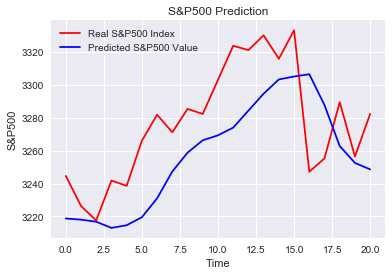

In [77]:
# Visualising the results

plt.plot(real_valuesSP500, color = 'red', label = 'Real S&P500 Index')
plt.plot(predicted_SP500value, color = 'blue', label = 'Predicted S&P500 Value')
plt.title('S&P500 Prediction')
plt.xlabel('Time')
plt.ylabel('S&P500')
plt.legend()
plt.show()


### 5. Implementing the Strategy  

A trading strategy based on the RNN algorithm can then be implemented where the S&P500 is bought at the current day closing time 
if it is predicted that the next day opening will be higher than current day opening and short sell the S&P500 at the closing trading if it is predicted that next day opening will be lower. 

In [78]:
#  
higher_lower_real = np.greater_equal(real_valuesSP500[1:], real_valuesSP500[0:len(real_valuesSP500) -1], ).astype(int)
higher_lower_predicted = np.greater_equal(predicted_SP500value[1:], predicted_SP500value[0:len(predicted_SP500value) -1], ).astype(int)

# replacing zeros by -1 to refer to the lower opening 
higher_lower_real[higher_lower_real == 0 ] = -1
higher_lower_predicted[higher_lower_predicted == 0 ] = -1

# the  + ones (- ones) indicate if the real and predicted value of next day opening was higher (lower) 
# hence if higher_lower_predicted indicates + one (- one) it means that the S&P500 should be bought (sold)
print('Real Direction of S&P500 Opening (Higher-Lower): ')
print(*higher_lower_real, sep=' ')
print('Predicted Direction of S&P500 Opening (Higher-Lower): ' )
print(' '.join(str(value) for value in higher_lower_predicted))

Real Direction of S&P500 Opening (Higher-Lower): 
[-1] [-1] [1] [-1] [1] [1] [-1] [1] [-1] [1] [1] [-1] [1] [-1] [1] [-1] [1] [1] [-1] [1]
Predicted Direction of S&P500 Opening (Higher-Lower): 
[-1] [-1] [-1] [1] [1] [1] [1] [1] [1] [1] [1] [1] [1] [1] [1] [1] [-1] [-1] [-1] [-1]


The Buy-and-Hold strategy of buying for 1000$ of the S&P500 and holding it during the month of January 2020 would have given a return of 1.29% or a profit of 12.90 dollars:

$$ 1000 * (1+ (3286 - 3244)/ 3244)) = 1012.90$$

Implementing the strategy based on the RNN model would give a profit of 68.25$ or 6.82% return. Note that this return is before trading fees which will almost surely impair the final return on the RNN strategy.

In [79]:
return_RNN = 1000
for i in range(len(higher_lower_predicted) - 1):
    return_RNN *= 1 + (higher_lower_predicted[i + 1] * (real_valuesSP500[i + 1] - real_valuesSP500[i])/real_valuesSP500[i])
print('Implementing the strategy based on the RNN model would give an outcome of:% 5.2f$'  %(return_RNN[0]))

Implementing the strategy based on the RNN model would give an outcome of: 1068.25$
